In [ ]:
# mounting the drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import History, ModelCheckpoint, EarlyStopping
from tensorflow.keras.regularizers import l2

# Q1: Visualizing Gene Expression Over Time and Exploring Class Differences
1. Single Sample Visualization: select a random sample from the dataset. Plot the expression levels of Gene 0 and Gene 1 across all time steps. Use different colors for each gene to distinguish their expression patterns.
2. Average Expression Trends: compute the mean expression of each gene across all samples at every time step. Plot the average expression of the selected genes over time. Add error bars to indicate standard deviation.
3. Separate samples based on the Outcome (Upregulated = 1, Downregulated = 0). Compute the average gene expression over time for each class. Plot the mean expression of Gene 0 and Gene 1 for both classes. Use separate line styles/colors to distinguish between the two classes.

### Discuss:
* Compare a random single sample with the average expression trend. Do any patterns emerge in the average that are not visible in the single sample?
When looking at a random single sample, the expression values appear to be more erratic and don't clearly reveal any consistent patterns to the eye. In contrast, the averaged trends (with standard deviation bars) show a smoother, more wave-like behavior, suggesting there is an underlying cyclical or oscillatory pattern across the population that's not immediately visible in any single noisy sample.

* Can you observe temporal patterns for Gene 0 and Gene 1 in the class difference plot?
Yes, the class-based plot indicates that both Gene 0 and Gene 1 exhibit time-dependent changes in expression, with disitinguishable peaks and troughs that vary between the upregulated and downregulated classes. This suggests that each gene follows a distinct temporal rythym that diverges between the two classes, reinforcing the idea that gene expression can fluctuate systematically over time and is influenced by class-specific factors.


Index(['Gene_0_T0', 'Gene_1_T0', 'Gene_2_T0', 'Gene_3_T0', 'Gene_4_T0',
       'Gene_5_T0', 'Gene_6_T0', 'Gene_7_T0', 'Gene_8_T0', 'Gene_9_T0',
       ...
       'Gene_1_T99', 'Gene_2_T99', 'Gene_3_T99', 'Gene_4_T99', 'Gene_5_T99',
       'Gene_6_T99', 'Gene_7_T99', 'Gene_8_T99', 'Gene_9_T99', 'Outcome'],
      dtype='object', length=1001)


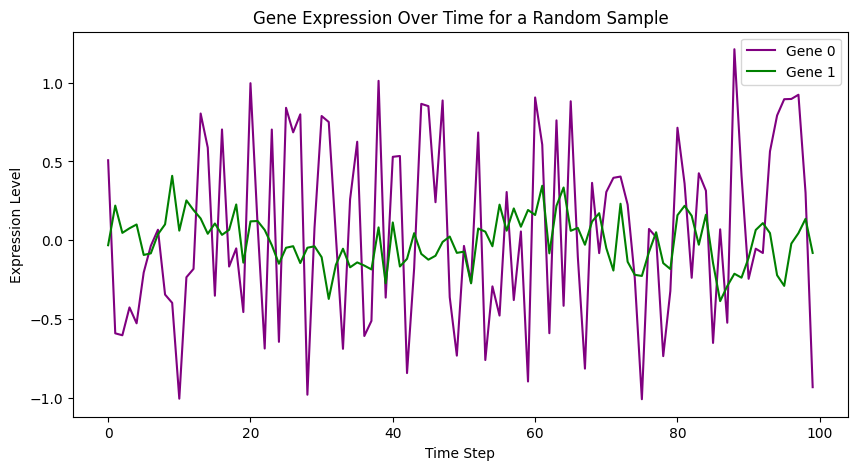

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/QBIO465/gene_expression_data.csv")
print(data.columns)
num_samples = 1000
num_genes = 10
num_time_steps = 100
gene_columns = [f'Gene_{gene}_T{t}' for gene in range(num_genes) for t in range(num_time_steps)]
# Extracting the expression data and reshaping it
expression_data = data[gene_columns].values.reshape(num_samples, num_genes, num_time_steps)
outcomes = data['Outcome'].values
np.random.seed(42)
sample_idx = np.random.randint(0, num_samples)
sample = expression_data[sample_idx]

# Plotting Gene 0 and Gene 1 expression over time for the random sample
plt.figure(figsize=(10, 5))
plt.plot(range(num_time_steps), sample[0, :], label='Gene 0', color='purple')
plt.plot(range(num_time_steps), sample[1, :], label='Gene 1', color='green')
plt.xlabel('Time Step')
plt.ylabel('Expression Level')
plt.title('Gene Expression Over Time for a Random Sample')
plt.legend()
plt.show()

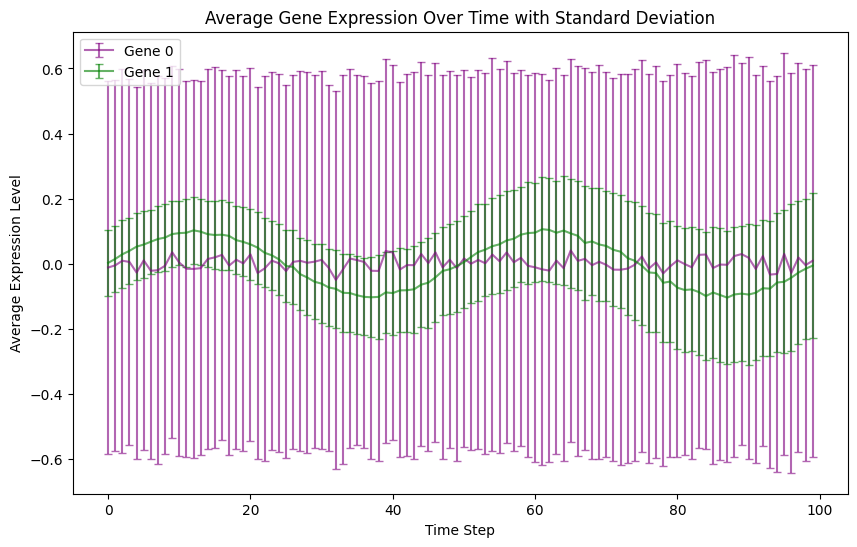

In [ ]:
mean_expression = expression_data.mean(axis=0)
std_expression = expression_data.std(axis=0)
plt.figure(figsize=(10, 6))
plt.errorbar(range(num_time_steps), mean_expression[0, :], yerr=std_expression[0, :], label='Gene 0', color = 'purple', alpha=0.6, capsize=3)
plt.errorbar(range(num_time_steps), mean_expression[1, :], yerr=std_expression[1, :], label='Gene 1', color = 'green', alpha=0.6, capsize=3)
plt.xlabel('Time Step')
plt.ylabel('Average Expression Level')
plt.title('Average Gene Expression Over Time with Standard Deviation')
plt.legend()
plt.show()

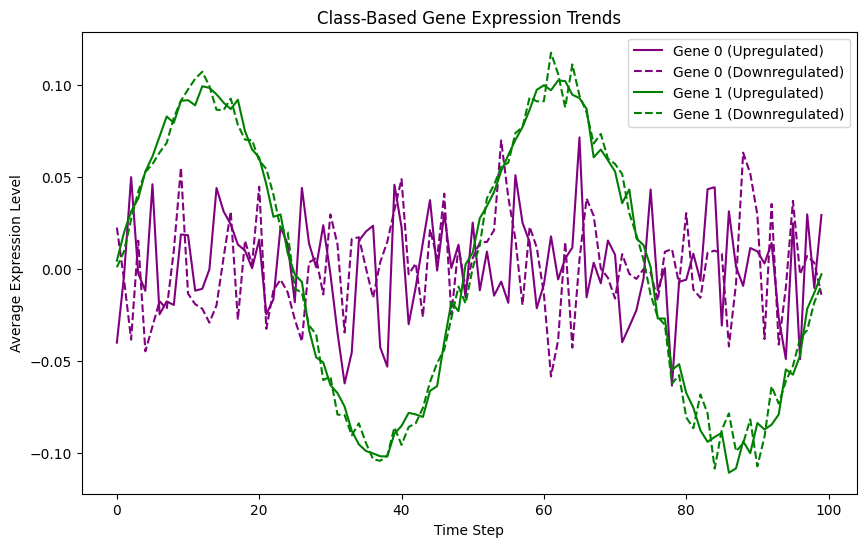

In [ ]:
class1_idx = np.where(outcomes == 1)[0]
class0_idx = np.where(outcomes == 0)[0]
class1_mean = expression_data[class1_idx].mean(axis=0)
class0_mean = expression_data[class0_idx].mean(axis=0)
plt.figure(figsize=(10, 6))
# Plot for Gene 0: solid line for upregulated, dashed for downregulated
plt.plot(range(num_time_steps), class1_mean[0, :], label='Gene 0 (Upregulated)', linestyle='-', color='purple')
plt.plot(range(num_time_steps), class0_mean[0, :], label='Gene 0 (Downregulated)', linestyle='--', color='purple')
# Plot for Gene 1: solid line for upregulated, dashed for downregulated
plt.plot(range(num_time_steps), class1_mean[1, :], label='Gene 1 (Upregulated)', linestyle='-', color='green')
plt.plot(range(num_time_steps), class0_mean[1, :], label='Gene 1 (Downregulated)', linestyle='--', color='green')

plt.xlabel('Time Step')
plt.ylabel('Average Expression Level')
plt.title('Class-Based Gene Expression Trends')
plt.legend()
plt.show()

# Q2: Fully Connected Neural Network (FCNN) for Gene Expression Classification
1. Load gene_expression_data.csv and divide it into training and testing sets (80-20% split)
2. Develop an FCNN with at least one hidden dense layer to classify gene expression dynamics into two classes (upregulation vs downregulation)
3. Train the model for 50 epochs, then report the training and testing accuracy and the training history.

### Discuss:
* How well does the FCNN perform? Were there any training/testing issues?
The FCNN shows high training accuracy (96.13%) but a substantially lower testing accuracy (68%), indicating that the model struggles to generalize to new, unseen data. There are lap gaps between training and testing accuracies which suggest overfitting.

* Suggest applicable techniques from class discussions to improve performance and justify your choices.
To mitigate overfitting, applying dropout regularization or weight decay could help reduce model complexity; additionally, using early stopping and cross-validation ensures that the model generalizes better by preventing it from training too long and by validating its performance across different data splits.



In [ ]:
# Splitting the data into training and testing sets 80/20
#print("Columns in the CSV:", data.columns.tolist())
# Using outcome as target label and all out columns as features
x = data.drop('Outcome', axis=1).values
y = data['Outcome'].values
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [ ]:
# Building the FCNN model
model = Sequential([
    Dense(64, activation='relu', input_shape=(x_train.shape[1],)),
    Dense(1, activation='sigmoid')
])
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Training for 50 epochs then evaluating
history = model.fit(x_train, y_train, epochs=50, batch_size=32, validation_split=0.1, verbose=1)
train_loss, train_accuracy = model.evaluate(x_train, y_train, verbose=0)
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=0)

print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Testing Accuracy: {test_accuracy:.4f}")
print("Training history keys:", history.history.keys())

Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 1.5079e-04 - val_accuracy: 0.6000 - val_loss: 1.3464
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.4273e-04 - val_accuracy: 0.6125 - val_loss: 1.3494
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.4265e-04 - val_accuracy: 0.6000 - val_loss: 1.3526
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 1.3538e-04 - val_accuracy: 0.6125 - val_loss: 1.3550
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.3639e-04 - val_accuracy: 0.6125 - val_loss: 1.3578
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 1.3317e-04 - val_accuracy: 0.6125 - val_loss: 1.3608
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 1.2901e-04 - val_accuracy: 0.6125 - val_loss: 1.3634
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.2536e-04 -

# Q3: LSTM Model for Temporal Gene Expression Classification
1. Preprocess the dataset to match the LSTM input shape: (num_samples, num_time_steps, num_genes)
2. Design an LSTM model for binary classification
3. Train the LSTM for 50 epochs, aiming for a test accuracy > 0.75. Start with 50 LSTM units.

### Discuss:
* How does the LSTM architecture capture temporal dependencies?
LSTMs capture temporal dependencies by using memory cells and gating mechanisms (input/forget/output fates) that regulate the flow of information across time steps, which allows the network to retain important features over long sequences while discarding irrelevant data.

* Suggest applicable technqiues from class discussions to improve performance and justify your choices.
Techniques such as dropout regularization and hyperparameter tuning (adjusting learning rates/LSTM counts) can reduce overfitting and enhance generalization, while incorporating bidirectional LSTM layers can further improve performance by capturing context from both past and future time steps, which is beneficial in complex sequential data.


In [ ]:
genes = 10
time_steps = 100
# Have to drop again if you already ran it
#x = data.drop('Outcome', axis=1).values
print("Original X shape:", x.shape)  # Should be (samples, 1000)
assert x.shape[1] == genes * time_steps, "!Mismatch in feature dimensions!"
# Reshaping x into a 3D shape (samples, time steps, genes)
x =x.reshape(-1, time_steps, genes)
print("Shape of x after reshaping: ", x.shape)
# SCALING THE DATA
samples = x.shape[0]
x_flat = x.reshape(samples, -1)
scaler = StandardScaler()
x_flat = scaler.fit_transform(x_flat)
x = x_flat.reshape(samples, time_steps, genes)
# Splitting the dataset again once reshaped
x_training, x_testing, y_training, y_testing = train_test_split(x, y, test_size=0.2, random_state=42)

Original X shape: (1000, 1000)
Shape of x after reshaping:  (1000, 100, 10)


In [ ]:
# Building the LSTM model for binary classification
lstm_model = Sequential([
    Bidirectional(LSTM(75, return_sequences=True, kernel_regularizer=l2(1e-4), input_shape=(time_steps, genes))),
    Bidirectional(LSTM(75, kernel_regularizer=l2(1e-4))),
    Dense(1, activation='sigmoid')
])
lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# Training the model for 50 epochs...accuracy above 0.75
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('best_lstm_model.h5', monitor='val_accuracy', save_best_only=True)
]
history = lstm_model.fit(x_training, y_training, epochs=50, batch_size=32, validation_split=0.2, callbacks=callbacks, verbose=1)
training_loss, training_accuracy = lstm_model.evaluate(x_training, y_training, verbose=0)
testing_loss, testing_accuracy = lstm_model.evaluate(x_testing, y_testing, verbose=0)
print("Training Accuracy: {:.2f}%".format(training_accuracy*100))
print("Testing Accuracy: {:.2f}%".format(testing_accuracy*100))

Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - accuracy: 0.6891 - loss: 0.6947

20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 232ms/step - accuracy: 0.6904 - loss: 0.6928 - val_accuracy: 0.7063 - val_loss: 0.5966
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.8429 - loss: 0.4592

20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 155ms/step - accuracy: 0.8417 - loss: 0.4598 - val_accuracy: 0.7188 - val_loss: 0.5473
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 156ms/step - accuracy: 0.8563 - loss: 0.4131 - val_accuracy: 0.7125 - val_loss: 0.5550
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.8469 - loss: 0.3840

20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 159ms/step - accuracy: 0.8467 - loss: 0.3837 - val_accuracy: 0.7625 - val_loss: 0.5272
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 158ms/step - accuracy: 0.8579 - loss: 0.3465 - val_accuracy: 0.7312 - val_loss: 0.5813
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 160ms/step - accuracy: 0.8915 - loss: 0.2860 - val_accuracy: 0.7125 - val_loss: 0.6389
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 150ms/step - accuracy: 0.9077 - loss: 0.2755 - val_accuracy: 0.7437 - val_loss: 0.6198
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 151ms/step - accuracy: 0.9266 - loss: 0.2380 - val_accuracy: 0.7625 - val_loss: 0.6164
Epoch 9/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 154ms/step - accuracy: 0.9283 - loss: 0.2204 - val_accuracy: 0.7188 - val_loss: 0.7604
Training Accuracy: 86.00%
Testing Accuracy: 80.50%


# Q4: LSTM Model Evaluation and FCNN Comparison
1. Evaluate the LSTM model using the same metrics as in Q2
2. Compare its performance against the FCNN model

### Discuss:
* How does the LSTM model compare to the FCNN?
The LSTM outperforms the FCNN on this time-series task because it captures sequential dependencies, while FCNN treats each input independently. The FCNN is simpler and can train faster which would make it more useful for non-sequential or less complex data.

* Which model better captures gene expression dynamics, and why?
The LSTM model better captures gene expression dynamics because it has a built-in memory mechanism (gates&cell states) that processes data sequentially. This allows it to better learn long-range correlations in gene expression over time.

* Conclude on the strengths and limitations of LSTMs versus FCNNs for this task
LSTMs excel in modeling sequential data with strong temporal depencies but are more complex and require more data to avoid overfitting. FCNNs are simpler, can be trained faster, and can be effective for static or less time-dependent tasks, but they typically miss subtle temporal patterns.


In [ ]:
loss, accuracy = lstm_model.evaluate(x_testing, y_testing, verbose=0)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

y_pred_proba=lstm_model.predict(x_testing)
y_pred = (y_pred_proba > 0.5).astype(int)
print("Classification Report (LSTM):")
print(classification_report(y_testing, y_pred))
print("Confusion Matrix (LSTM):")
print(confusion_matrix(y_testing, y_pred))

Test Loss: 0.4510
Test Accuracy: 0.8050
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
Classification Report (LSTM):
              precision    recall  f1-score   support

           0       0.78      0.73      0.75        82
           1       0.82      0.86      0.84       118

    accuracy                           0.81       200
   macro avg       0.80      0.79      0.80       200
weighted avg       0.80      0.81      0.80       200

Confusion Matrix (LSTM):
[[ 60  22]
 [ 17 101]]


In [118]:
#!pip install
!jupyter nbconvert --to html "/content/drive/MyDrive/QBIO465/SEB QBIO465 HW5.ipynb"

[NbConvertApp] Converting notebook /content/drive/MyDrive/QBIO465/SEB QBIO465 HW5.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 3 image(s).
[NbConvertApp] Writing 727477 bytes to /content/drive/MyDrive/QBIO465/SEB QBIO465 HW5.html
